In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

In [2]:
# Importing necessary libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
# Ensuring the GPU is being used
Physical_Devices = tf.config.experimental.list_physical_devices('GPU')
if len(Physical_Devices) > 0:
  tf.config.experimental.set_memory_growth(Physical_Devices[0],True)
  print('GPU is being used.')
else:
  print('GPU is not being used.')



GPU is not being used.


In [ ]:
# Path to the dataset

dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

# List all the classes (Animal Types)
classes = os.listdir(dataset_path)
classes.sort()  # Sort the classes list alphabetically
num_classes = len(classes)

#Display the number of classes along with names
print(f'Number of Classes:{num_classes}')
print(f'Classes:{classes}')

Number of Classes:90
Classes:['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


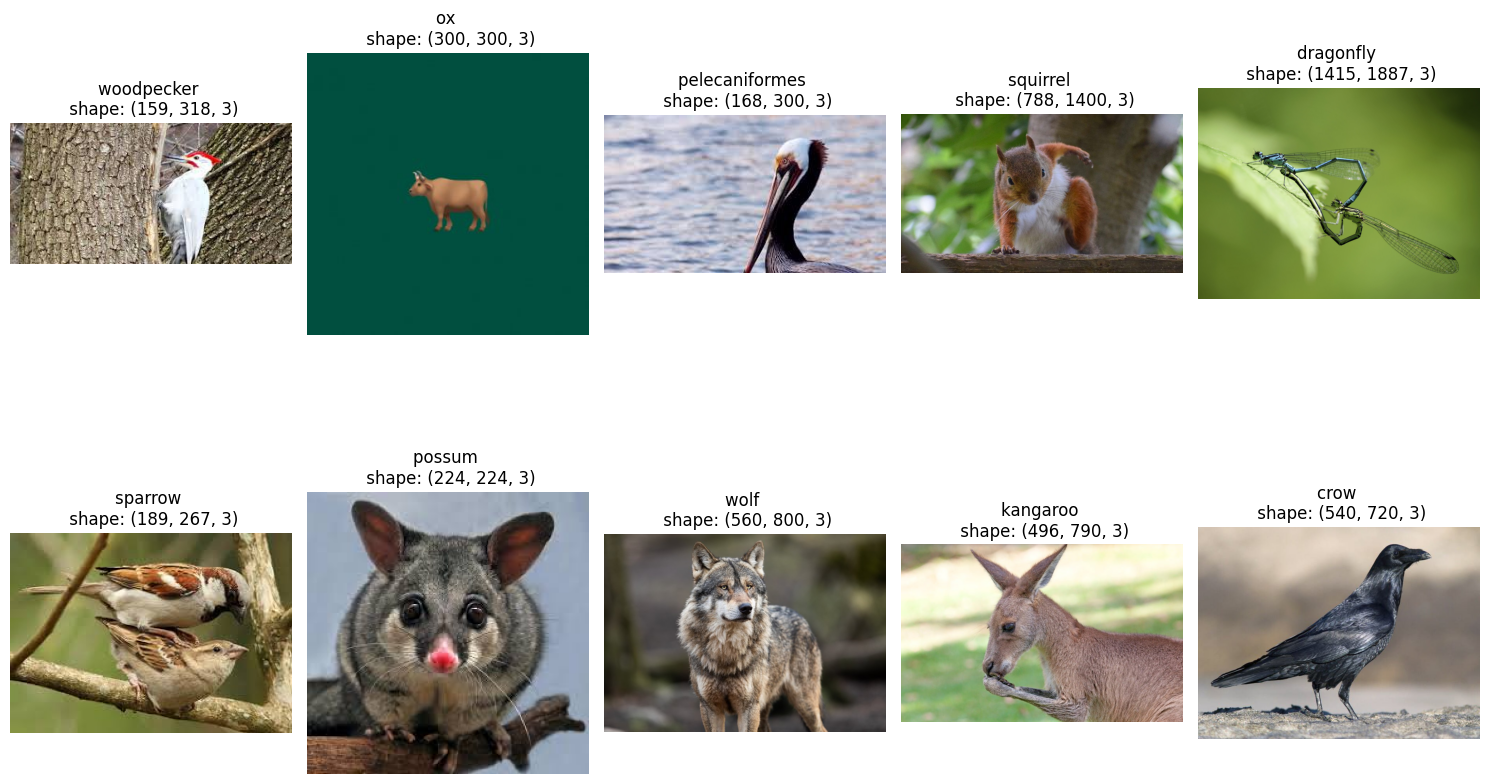

In [17]:
# Visualize some sample images form the dataset

def visualize_images(dataset_path, classes, num_images=10):
    plt.figure(figsize=(15, 10))

    # Select a random subset of classes for better diversity
    selected_classes = random.sample(classes, min(num_images, len(classes)))

    for i, class_name in enumerate(selected_classes):
        class_path = os.path.join(dataset_path, class_name)

        # Error handling for empty class directories
        if not os.listdir(class_path):
            print(f"Warning: Class '{class_name}' directory is empty. Skipping...")
            continue

        # Select a random image from the class directory
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)

        try:
            img = plt.imread(img_path)
            plt.subplot(2, 5, i + 1)  # Adjust subplot layout if num_images > 10
            plt.imshow(img)
            plt.title(f'{class_name} \n shape: {img.shape}')
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image '{img_path}': {e}")

    plt.tight_layout()
    plt.show()

# Call the function to visualize images
visualize_images(dataset_path, classes)

In [7]:
# 2. Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Reduced for potential improvement
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=classes  # Explicitly specifying classes for correct labeling
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=classes  # Explicitly specifying classes
)

# 3. Model Building
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  # GlobalAveragePooling often performs better
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


# 4. Model Compilation and Training
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,  # Increased for potentially better learning
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]  # Added early stopping
)

# 5. Model Evaluation and Saving
model.save("animal_classifier_model.h5")

val_loss, val_acc = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

Found 4320 images belonging to 90 classes.
Found 1080 images belonging to 90 classes.


C:\Users\TITAN\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 118s 851ms/step - accuracy: 0.0575 - loss: 4.5276 - val_accuracy: 0.4962 - val_loss: 3.0682
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 127s 942ms/step - accuracy: 0.3921 - loss: 2.8515 - val_accuracy: 0.6619 - val_loss: 1.8230
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 130s 966ms/step - accuracy: 0.6041 - loss: 1.8236 - val_accuracy: 0.7367 - val_loss: 1.2822
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 121s 894ms/step - accuracy: 0.6825 - loss: 1.3454 - val_accuracy: 0.7481 - val_loss: 1.1123
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 126s 930ms/step - accuracy: 0.7193 - loss: 1.1240 - val_accuracy: 0.7680 - val_loss: 0.9831
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 125s 928ms/step - accuracy: 0.7626 - loss: 0.9337 - val_accuracy: 0.7652 - val_loss: 0.9350
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 122s 902ms/step - accuracy: 0.7913 - loss: 0.8125 - val_accuracy: 0.7689 - val_loss: 0.8897
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 110s 812ms/step - accuracy: 0.8082 -

34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 357ms/step - accuracy: 0.8068 - loss: 0.7341
Validation Loss: 0.6959473490715027
Validation Accuracy: 0.8138889074325562


In [8]:
from sklearn.metrics import classification_report

# Generate classification report
validation_generator.reset()  # Reset the validation generator
val_predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
# +1 to cover all samples
val_predictions = np.argmax(val_predictions, axis=1)

# Get the true labels for the validation set
y_true = validation_generator.classes

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_true, val_predictions[:len(y_true)], target_names=classes))  # Slice predictions to match true labels

34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 381ms/step
Classification Report:
                precision    recall  f1-score   support

      antelope       0.92      0.92      0.92        12
        badger       1.00      0.67      0.80        12
           bat       0.50      0.75      0.60        12
          bear       0.69      0.92      0.79        12
           bee       1.00      1.00      1.00        12
        beetle       0.71      0.83      0.77        12
         bison       1.00      1.00      1.00        12
          boar       0.77      0.83      0.80        12
     butterfly       0.85      0.92      0.88        12
           cat       0.75      0.75      0.75        12
   caterpillar       0.71      1.00      0.83        12
    chimpanzee       1.00      0.92      0.96        12
     cockroach       1.00      1.00      1.00        12
           cow       0.53      0.75      0.62        12
        coyote       1.00      0.83      0.91        12
          crab       0.85      0.92   

In [ ]:
from IPython.display import display
from ipywidgets import FileUpload, Output
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Output_widget = Output()

# Create a file upload widget
upload_widget = FileUpload(accept='.jpg,.jpeg,.png,.bmp', multiple=False)
display(upload_widget, Output_widget)

class_names = classes  # Update this with your actual class names

# Function to handle file upload and prediction
def on_upload_change(change):
    # Check if files are uploaded
    if upload_widget.value:
        # Extract the first uploaded file from the tuple
        uploaded_file = upload_widget.value[0]  # Access the first file in the tuple
        
        file_content = uploaded_file['content']
        file_name = uploaded_file['name']

        # Save the uploaded file to disk
        with open(file_name, 'wb') as f:
            f.write(file_content)  

        # Load the trained model
        model = tf.keras.models.load_model("animal_classifier_model.h5")

        # Load and preprocess the image
        img = image.load_img(file_name, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make the prediction
        prediction = model.predict(img_array)

        # Get the predicted class index and name
        predicted_class_index = np.argmax(prediction)
        predicted_class_name = class_names[predicted_class_index]


        # Print the prediction
        with Output_widget:
            Output_widget.clear_output(wait=True)
            # print(f"Predicted Animal:", predicted_class_name.upper())

            # Display the image with prediction
            img = mpimg.imread(file_name)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f":: Animal Recognition ::\n\nPredicted Animal: {predicted_class_name.upper()}")
            plt.show()

        # Delete the image file after processing
        if os.path.exists(file_name):
            os.remove(file_name)  # Delete the file

# Set up the event listener for file upload
upload_widget.observe(on_upload_change, names='value')


FileUpload(value=(), accept='.jpg,.jpeg,.png,.bmp', description='Upload')

Output()